# Load libaries

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import torch
from torchmetrics import MeanSquaredError
from iterativenn.nn_modules.Sequential1D import Sequential1D
import pytorch_lightning as pl
from scipy.signal import savgol_filter

from iterativenn.utils.model_factory import ModelFactory_callback

# Introduction

This notebook is intended to be, in as simple a way as possible, a demonstration of growing an INN from a least squares problem.  There will be three solutions here:

1.  The least squares solution
2.  A classic MLP solution
3.  An INN solution grown from the least squares solution

We will get several benefits from this:

1.  This will be a baseline solution to any problem that can be phrased as a mapping from X to Y (e.g., MNIST, EM, graphs, etc.)
2.  It will be a sanity check on the MLP and INN solutions.  I.e., they should be able to learn the same thing as the least squares solution, if not better.
3.  It will be a starting place for any student working on similar problems. 


# Preliminaries

We want this notebook to be as simple and as general as possible, so all problem dependent code will be here.

In [2]:
X_orig_train = torch.load('/home/rcpaffenroth/projects/collaborators/gnn_anura/X_Train.pt')
Y_orig_train = torch.load('/home/rcpaffenroth/projects/collaborators/gnn_anura/Y_Train.pt')
X_orig_test = torch.load('/home/rcpaffenroth/projects/collaborators/gnn_anura/X_Validation.pt')
Y_orig_test = torch.load('/home/rcpaffenroth/projects/collaborators/gnn_anura/Y_Validation.pt')

# Training size
# To make things faster, we'll only use a subset of the data
train_size = X_orig_train.shape[0]
test_size = X_orig_test.shape[0]

# the batch size to use for all trained models
batch_size = 1024
optimizer_factory = torch.optim.RMSprop

# Max epochs for all trained models
Trained_LS_max_epochs = 5000
MLP_max_epochs = 5000
INN_max_epochs = 5000

# learning rate for all trained models
Trained_LS_learning_rate = 0.01*200
MLP_learning_rate = 0.001
INN_learning_rate = 0.001

# Note, the first and last later sizes are fixed by the number of columns in X and Y
MLP_layer_sizes = [X_orig_train.shape[1], 70, 100, 150, Y_orig_train.shape[1]]
MLP_activation = torch.nn.ELU()

# number of hidden values in the INN
INN_hidden_size = 112
# number of hidden values in the INN
INN_iterations = 3
# activation function for the INN
INN_activation = 'ELU'


In [3]:
# data for the final summary
summary = []

# Setup

We do some basic setup and sanity checks.

In [4]:
# We have the correct number of training and test samples
assert X_orig_train.shape[0] == Y_orig_train.shape[0]
assert X_orig_test.shape[0] == Y_orig_test.shape[0]

# We have the same number of features in the training and test sets
assert X_orig_train.shape[1] == X_orig_test.shape[1]
assert Y_orig_train.shape[1] == Y_orig_test.shape[1]

In [5]:
print('training data orig shape:')
print (f'X {X_orig_train.shape}')
print (f'Y {Y_orig_train.shape}')

print('testing data orig shape:')
print (f'X {X_orig_test.shape}')
print (f'Y {Y_orig_test.shape}')

training data orig shape:
X torch.Size([3000, 45])
Y torch.Size([3000, 112])
testing data orig shape:
X torch.Size([1000, 45])
Y torch.Size([1000, 112])


In [6]:
perm = torch.randperm(X_orig_train.shape[0])
idx = perm[:train_size]
X_train = X_orig_train[idx, :]
Y_train = Y_orig_train[idx, :]

In [7]:
perm = torch.randperm(X_orig_test.shape[0])
idx = perm[:test_size]
X_test = X_orig_test[idx, :]
Y_test = Y_orig_test[idx, :]

In [8]:
print('training data shape:')
print (f'X {X_train.shape}')
print (f'Y {Y_train.shape}')

print('testing data shape:')
print (f'X {X_test.shape}')
print (f'Y {Y_test.shape}')

training data shape:
X torch.Size([3000, 45])
Y torch.Size([3000, 112])
testing data shape:
X torch.Size([1000, 45])
Y torch.Size([1000, 112])


# Functions

In [9]:
def least_squares(X, Y, device=None, dtype=None):
    """
    Returns a Linear object that is the least squares solution to the problem X -> Y.
    This function initializes the initial weights "weight_0" and the update "U" 
    to be the optimal least squares solution to the linear regression problem
    which maps the input X to the output Y.  This is done by computing

    :math:`
        XW=Y\\
        X^T X W = X^T Y \\
        (X^T X)^{-1} X^T X W = (X^T X)^{-1} X^T Y \\
        W = (X^T X)^{-1} X^T Y 
    `
    Args:
    X: A tensor of shape (N, D) where N is the number of samples and D is the number of features.
    Y: A tensor of shape (N, K) where N is the number of samples and K is the number of outputs.
    device: The device to use for the Linear object.
    dtype: The dtype to use for the Linear object.
    """
    X_size = X.shape[1]
    Y_size = Y.shape[1]
    A = torch.nn.Linear(in_features=X_size, out_features=Y_size, bias=False, device=device, dtype=dtype)
    with torch.no_grad():
        W_init = (torch.inverse(X.T @ X)@X.T@Y).T
        # The requires_grad=Fase is important, otherwise the gradient will be computed when we don't want it to.
        A.weight[:, :] = W_init
    mse_loss = torch.nn.MSELoss()
    loss = mse_loss(A(X), Y) 
    A.losses = [float(loss)] * 1000
    return A

In [10]:
def to_1D(Z):
    """Given a tensor Z, returns a 1D tensor with the same number of rows as Z,
    but with each row projected onto a single column.

    Args:
        Z (Tensor): the possibly multi-dimensional tensor to project onto a single dimension.

    Returns:
        Tensor : A 1D projection of Z.
    """
    Z = Z.detach()
    if Z.shape[1] == 1:
        return Z.reshape(-1)
    else:
        U,S,V = torch.pca_lowrank(Z)
        Z_1D = torch.matmul(Z, V[:, :1])
        return Z_1D.reshape(-1)

In [11]:
class LitModule(pl.LightningModule):
    def __init__(self, module, learning_rate):
        super().__init__()
        self.module = module
        self.in_features = module.in_features
        self.out_features = module.out_features
        self.learning_rate = learning_rate
        self.losses = []
    
    def forward(self, X):
        return self.module(X)

    def training_step(self, batch, batch_idx):
        X,Y = batch
        Y_hat = self.module(X)
        # Both are training on the MSE loss (not RMSE)
        loss = torch.nn.functional.mse_loss(Y_hat, Y)
        self.losses.append(float(loss))
        return loss
    
    def configure_optimizers(self):
        optimizer = optimizer_factory(self.parameters(), lr=self.learning_rate)
        return optimizer

In [12]:
class LitIteratedModule(pl.LightningModule):
    def __init__(self, module, callbacks, learning_rate, iterations=1):
        super().__init__()
        self.module = module
        self.callbacks = callbacks
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.losses = []
    
    def forward(self, X):
        Z = self.callbacks.initialization(X.device, rows=X.shape[0])
        Z = self.callbacks.data(Z, X, 0, None)
        for i in range(self.iterations):
            Z = self.module(Z)
        return self.callbacks.output(Z, 0, None, None)

    def training_step(self, batch, batch_idx):
        X,Y = batch
        Z = self.callbacks.initialization(X.device, rows=X.shape[0])
        Z = self.callbacks.data(Z, X, 0, None)
        # Note, the lost is returned for every iteration.
        # Sometimes it might be 0 (e.g., when loss type is 'last')
        loss = 0
        for i in range(self.iterations):
            Z = self.module(Z)        
            # Both are training on the MSE loss (not RMSE)
            loss += self.callbacks.loss(Z, Y, i, range(self.iterations))
        self.losses.append(float(loss))
        return loss    

    def configure_optimizers(self):
        optimizer = optimizer_factory(self.parameters(), lr=self.learning_rate)
        return optimizer

In [13]:
def get_cfg(previous_module, grow_weight_std=0.01, m=X_train.shape[1], n=Y_train.shape[1], k=INN_hidden_size):
    default_kwargs = {'block_type':'W', 'initialization_type':f'G=0.0,{grow_weight_std}', 'trainable':True, 'bias':False}

    default_module = 'MaskedLinear.from_description'
    print(f'predicted INN_trainable_params: {m*k+2*n*k+k**2}')
    cfg = {
        "model_type": "sequential2D",   
        "in_features_list": [m, n, k], 
        "out_features_list": [m, n, k], 

        "activations" : ['Identity', 'Identity', INN_activation],
        "activation_sizes" : [m, n, k],
        "callbacks": {
            "loss": {
                "func": "MSELoss",
                "idx_list" : range(m, m+n),
                # Change this to 'all' to use all the losses during the iteration
                # "sequence_position": 'all',
                "sequence_position": 'last',
            },
            "initialization": {
                "func": "zeros",
                "size": m+n+k,
            },
            "data": {
                "func": "insert",
                "idx_list": range(0, m),
                "flatten_input": False,
            },
            "output": {
                "func": "all",
                "idx_list" : range(m, m+n)
            },
        }
    }
    cfg["block_types"] = [
            ['Identity',     'Module',       default_module],
            [None,           None,           default_module],
            [None,           default_module, default_module]]
    cfg["block_kwargs"] = [
            [None,           {'module':previous_module, 'trainable': False}, default_kwargs],
            [None,           None,                                           default_kwargs],
            [None,           default_kwargs,                                 default_kwargs]]
    return cfg

In [14]:
def evaluate_modules(modules, names, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test):
    legends_error = []
    legends_loss = []
    rmse = MeanSquaredError(squared=False)
    f, ax = plt.subplots(ncols=2, figsize=(12, 6))
    for module, name in zip(modules, names):
        # ax[0].plot(to_1D(Y_train), to_1D(module(X_train)), '.')
        # legends_error.append(f'{name} Train')
        # ax[0].plot(to_1D(Y_test), to_1D(module(X_test)), '.')
        # legends_error.append(f'{name} Test')
        # print(f'{name} Training error : {rmse(module(X_train), Y_train).item()}')
        # print(f'{name} Testing error : {rmse(module(X_test), Y_test).item()}')
        ax[1].semilogy(module.losses)
        legends_loss.append(name)
        # y = savgol_filter(module.losses, 1000, 1)
        # ax[1].plot(y)
        # legends_loss.append(name+' (smoothed)')
        # ax[1].set_ylim(0,2)

    ax[0].set_xlabel('True')
    ax[0].set_ylabel('Predicted')
    ax[0].legend(legends_error)
    ax[1].set_xlabel('Step')
    ax[1].set_ylabel('Loss')
    ax[1].legend(legends_loss)

    f.tight_layout()

In [15]:
def train_module(module, max_epochs):
    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    trainer = pl.Trainer(max_epochs=max_epochs,
                         devices=1 if torch.cuda.is_available() else None,
                         accelerator='auto')
    trainer.fit(model=module, train_dataloaders=train_dataloader)

# Least squares solution

In [16]:
least_squares_module = least_squares(X_train, Y_train)

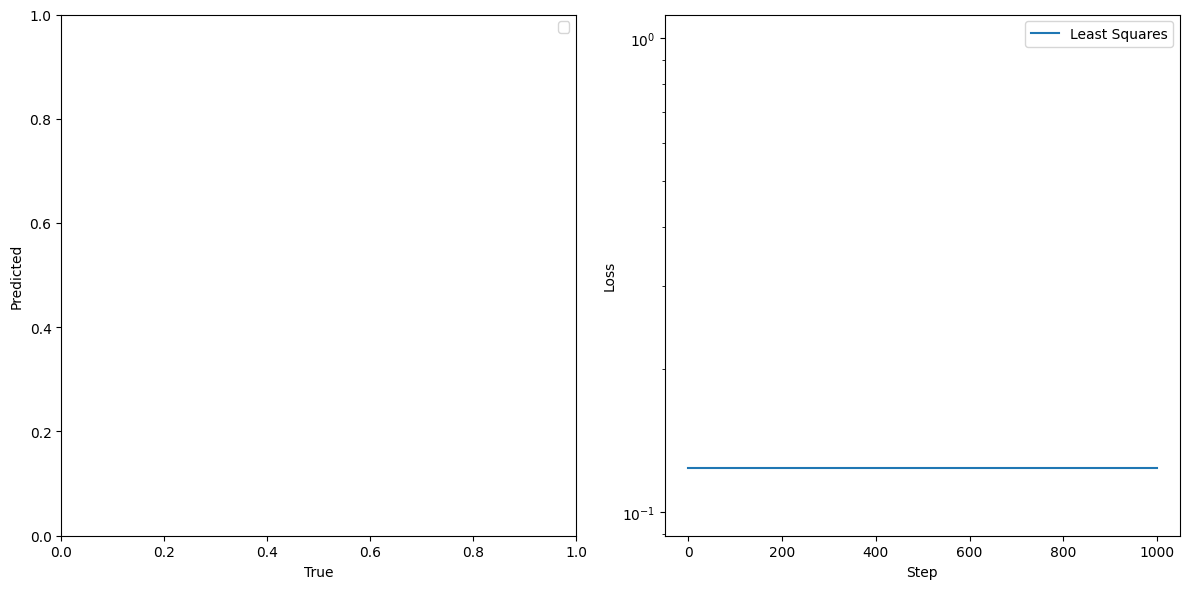

In [17]:
evaluate_modules([least_squares_module], ['Least Squares'])

In [18]:
summary_dict = {}
summary_dict['module'] = least_squares_module
summary_dict['name'] = 'Least Squares'
summary_dict['trainable parameters'] = 0
summary.append(summary_dict)

# Trained least squares solution

In [19]:
# Sequential1D is just a wrapper around nn.Sequential that
# records the input and output sizes of the network.  This is useful
# for the INN solution below as the MLP can be used as a block in an INN.
# However, the as far as this part is concerned, it is identical to nn.Sequential.
trained_least_squares = Sequential1D(in_features=MLP_layer_sizes[0],
                                     out_features=MLP_layer_sizes[-1]) 

trained_least_squares.add_module('linear0', torch.nn.Linear(X_train.shape[1], Y_train.shape[1], bias=False))
trained_least_squares_module = LitModule(trained_least_squares, learning_rate=Trained_LS_learning_rate)

In [20]:
train_module(trained_least_squares_module, Trained_LS_max_epochs)

/home/rcpaffenroth/projects/iterativenn/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/rcpaffenroth/projects/iterativenn/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type         | Params
----------------------------------------
0 | module | Sequential1D | 5.0 K 
----------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     To

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


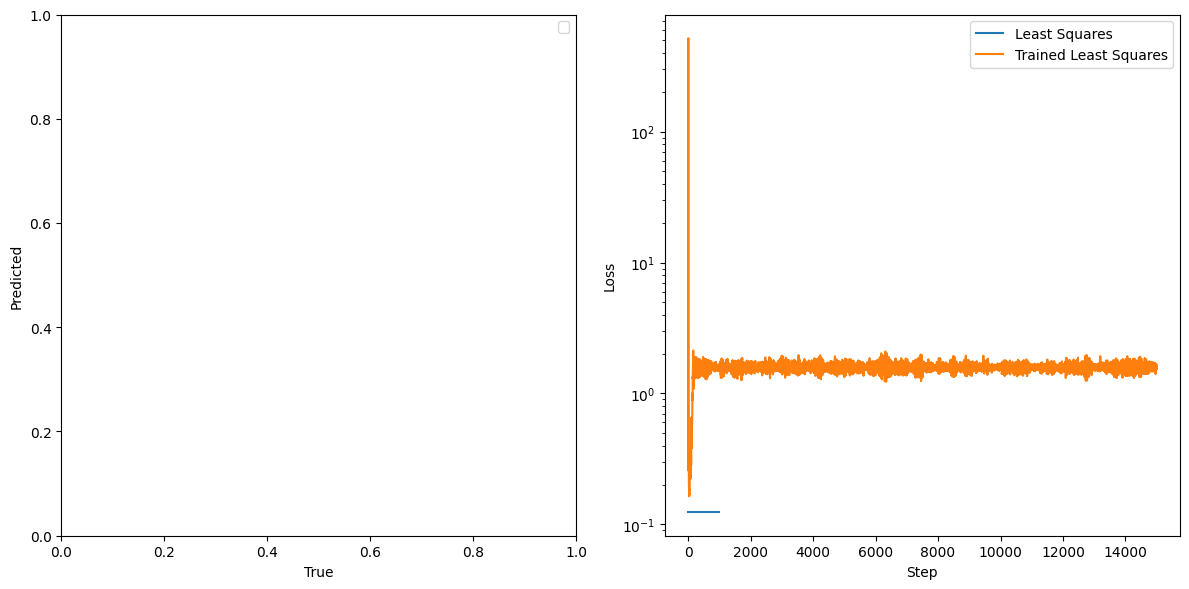

In [21]:
evaluate_modules([least_squares_module, trained_least_squares_module], ['Least Squares', 'Trained Least Squares'])

In [22]:
summary_dict = {}
summary_dict['module'] = trained_least_squares_module
summary_dict['name'] = 'Trained Least Squares'
summary_dict['trainable parameters'] = sum(p.numel() for p in summary_dict['module'].parameters() if p.requires_grad)
summary.append(summary_dict)

# MLP solution

In [23]:
# Sequential1D is just a wrapper around nn.Sequential that
# records the input and output sizes of the network.  This is useful
# for the INN solution below as the MLP can be used as a block in an INN.
# However, the as far as this part is concerned, it is identical to nn.Sequential.
mlp = Sequential1D(in_features=MLP_layer_sizes[0],
                   out_features=MLP_layer_sizes[-1]) 

for i in range(len(MLP_layer_sizes)-1):
    mlp.add_module(f'linear{i}', 
                   torch.nn.Linear(MLP_layer_sizes[i], MLP_layer_sizes[i+1]))
    # always end with a linear layer
    if i < len(MLP_layer_sizes)-2:        
        mlp.add_module(f'activation{i}', 
                       MLP_activation)
mlp_module = LitModule(mlp, MLP_learning_rate)


In [24]:
train_module(mlp_module, MLP_max_epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type         | Params
----------------------------------------
0 | module | Sequential1D | 42.4 K
----------------------------------------
42.4 K    Trainable params
0         Non-trainable params
42.4 K    Total params
0.170     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


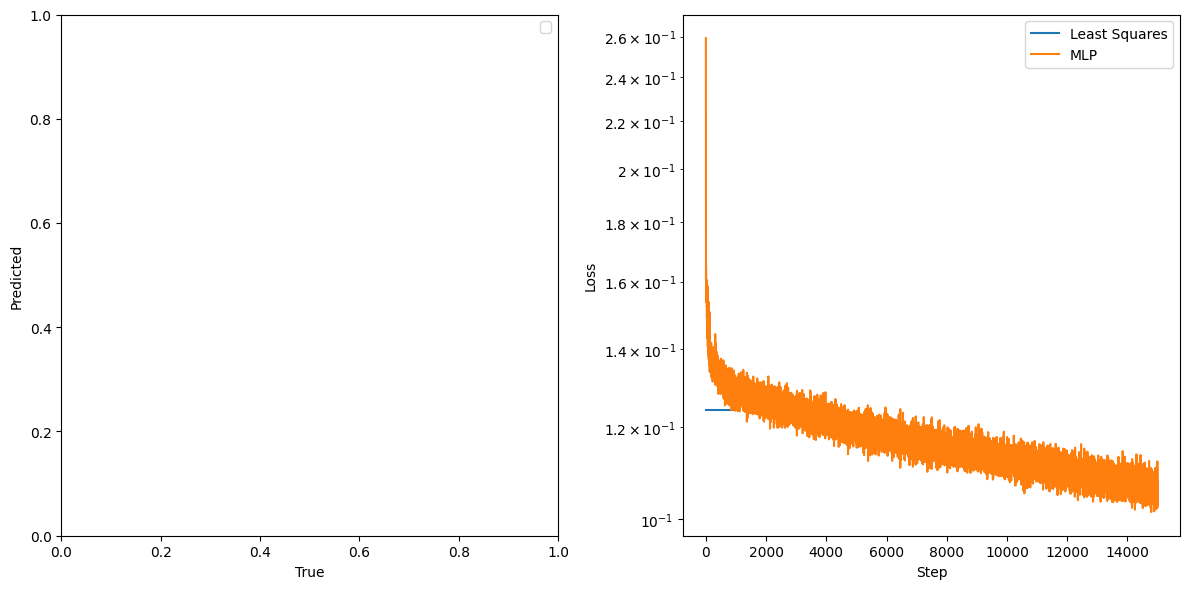

In [25]:
evaluate_modules([least_squares_module, mlp_module], ['Least Squares', 'MLP'])

In [26]:
summary_dict = {}
summary_dict['module'] = mlp_module
summary_dict['name'] = 'MLP'
summary_dict['trainable parameters'] = sum(p.numel() for p in summary_dict['module'].parameters() if p.requires_grad)
summary.append(summary_dict)

# INN solution, least squares grown

In [27]:
module = ModelFactory_callback(get_cfg(least_squares_module))
inn_LS_grown_module = LitIteratedModule(module.model, module.callbacks, INN_learning_rate, iterations=INN_iterations)

predicted INN_trainable_params: 42672


In [28]:
train_module(inn_LS_grown_module, INN_max_epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type         | Params
----------------------------------------
0 | module | Sequential1D | 133 K 
----------------------------------------
42.7 K    Trainable params
90.4 K    Non-trainable params
133 K     Total params
0.532     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


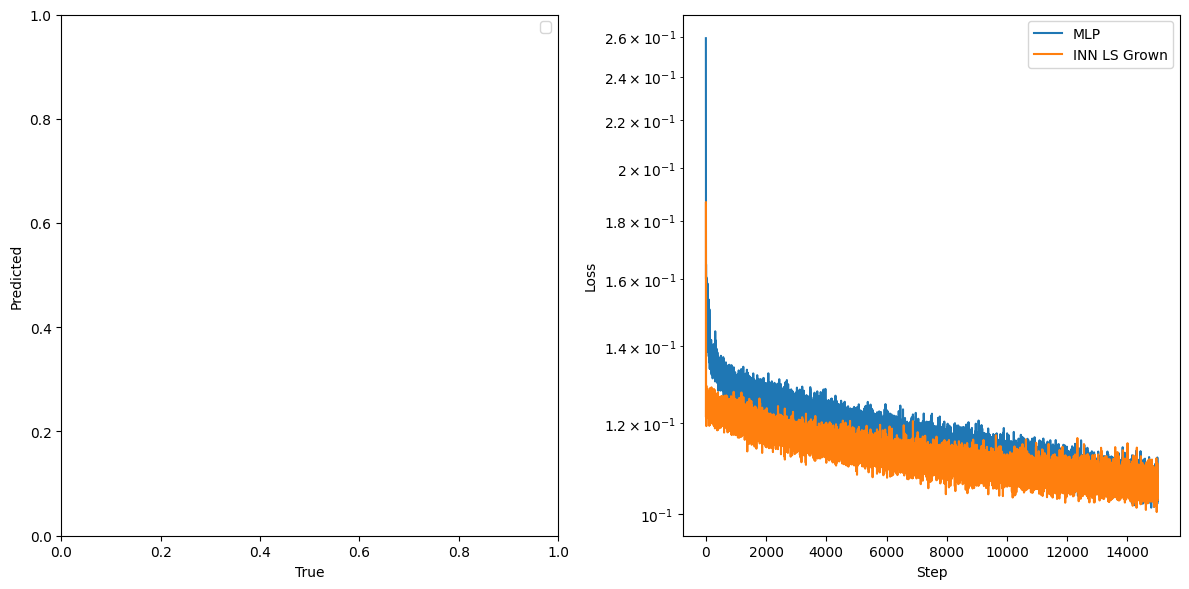

In [29]:
evaluate_modules([mlp_module, inn_LS_grown_module], ['MLP', 'INN LS Grown'])

In [30]:
summary_dict = {}
summary_dict['module'] = inn_LS_grown_module
summary_dict['name'] = 'INN LS Grown'
summary_dict['trainable parameters'] = sum(p.numel() for p in summary_dict['module'].parameters() if p.requires_grad)
summary.append(summary_dict)

# INN solution, trained least squares grown

In [31]:
module = ModelFactory_callback(get_cfg(trained_least_squares))
inn_trained_LS_grown_module = LitIteratedModule(module.model, module.callbacks, INN_learning_rate, iterations=INN_iterations)

predicted INN_trainable_params: 42672


In [32]:
train_module(inn_trained_LS_grown_module, INN_max_epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type         | Params
----------------------------------------
0 | module | Sequential1D | 133 K 
----------------------------------------
42.7 K    Trainable params
90.4 K    Non-trainable params
133 K     Total params
0.532     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


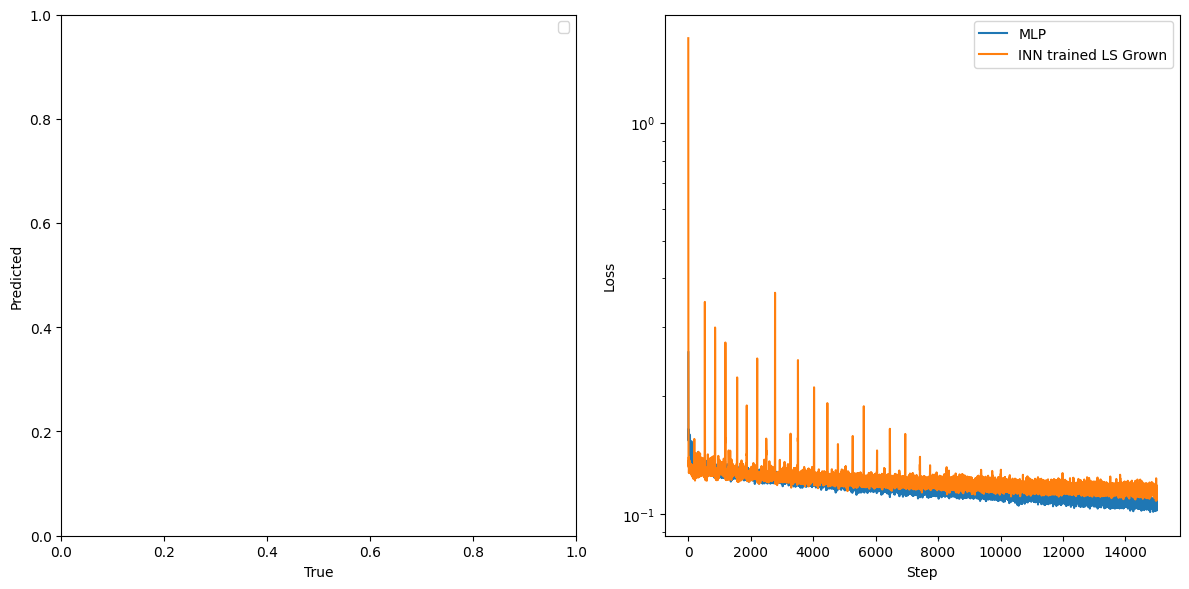

In [33]:
evaluate_modules([mlp_module, inn_trained_LS_grown_module], ['MLP', 'INN trained LS Grown'])

In [34]:
summary_dict = {}
summary_dict['module'] = inn_trained_LS_grown_module
summary_dict['name'] = 'INN Trained Least Squares'
summary_dict['trainable parameters'] = sum(p.numel() for p in summary_dict['module'].parameters() if p.requires_grad)
summary.append(summary_dict)

# INN solution (random start)

In [35]:
random_start = Sequential1D(in_features=MLP_layer_sizes[0],
                            out_features=MLP_layer_sizes[-1]) 
linear0 = torch.nn.Linear(X_train.shape[1], Y_train.shape[1], bias=False, device=X_train.device)
for param in linear0.parameters():
    param.requires_grad = False

random_start.add_module('linear0', linear0)

In [36]:
module = ModelFactory_callback(get_cfg(random_start))
inn_random_grown_module = LitIteratedModule(module.model, module.callbacks, INN_learning_rate, iterations=INN_iterations)

predicted INN_trainable_params: 42672


In [37]:
train_module(inn_random_grown_module, INN_max_epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type         | Params
----------------------------------------
0 | module | Sequential1D | 133 K 
----------------------------------------
42.7 K    Trainable params
90.4 K    Non-trainable params
133 K     Total params
0.532     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


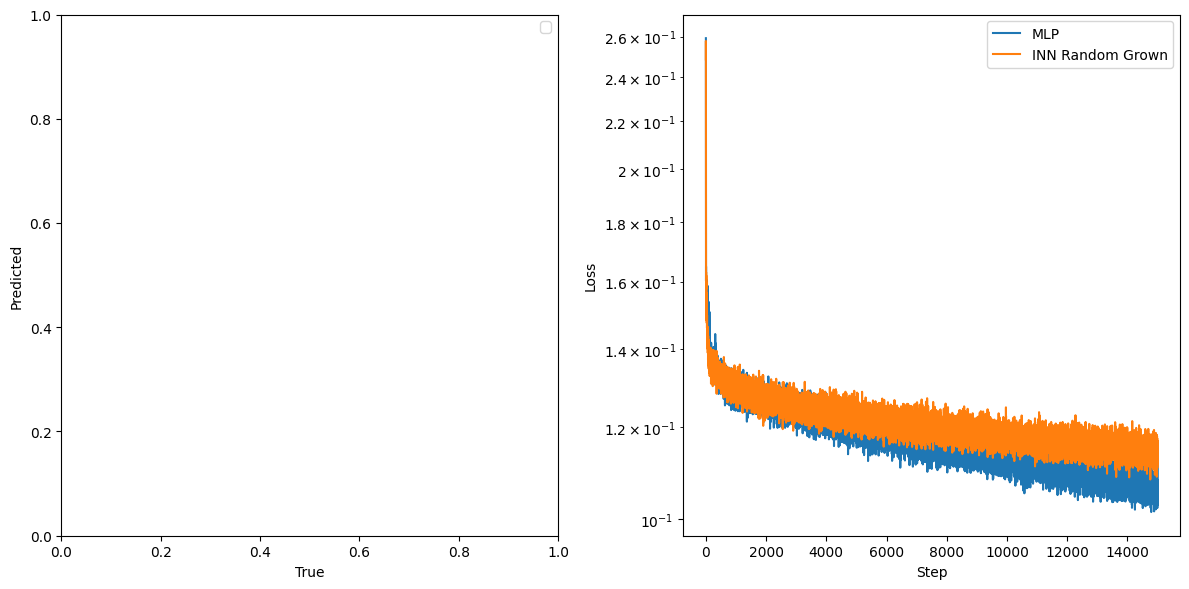

In [38]:
evaluate_modules([mlp_module, inn_random_grown_module], ['MLP', 'INN Random Grown'])

In [39]:
summary_dict = {}
summary_dict['module'] = inn_random_grown_module
summary_dict['name'] = 'INN Random Grown'
summary_dict['trainable parameters'] = sum(p.numel() for p in summary_dict['module'].parameters() if p.requires_grad)
summary.append(summary_dict)

# INN solution (MLP start)

In [40]:
module = ModelFactory_callback(get_cfg(mlp))
inn_mlp_grown_module = LitIteratedModule(module.model, module.callbacks, INN_learning_rate, iterations=INN_iterations)

predicted INN_trainable_params: 42672


In [41]:
train_module(inn_mlp_grown_module, INN_max_epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type         | Params
----------------------------------------
0 | module | Sequential1D | 170 K 
----------------------------------------
42.7 K    Trainable params
127 K     Non-trainable params
170 K     Total params
0.682     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


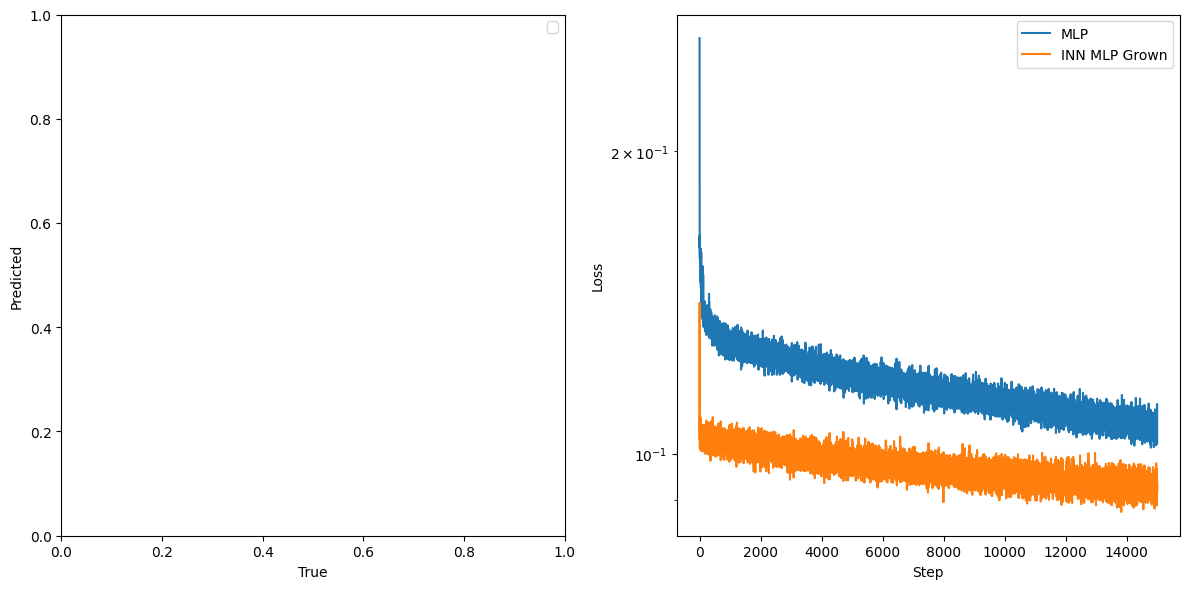

In [42]:
evaluate_modules([mlp_module, inn_mlp_grown_module], ['MLP', 'INN MLP Grown'])

In [43]:
summary_dict = {}
summary_dict['module'] = inn_mlp_grown_module
summary_dict['name'] = 'INN MLP Grown'
summary_dict['trainable parameters'] = sum(p.numel() for p in summary_dict['module'].parameters() if p.requires_grad)
summary.append(summary_dict)

In [44]:
rmse = MeanSquaredError(squared=False)
for summary_dict in summary:
    print(f'{summary_dict["name"]} trainable params: {summary_dict["trainable parameters"]}')
    print(f'{summary_dict["name"]} Training error : {rmse(summary_dict["module"](X_train), Y_train).item()}')
    print(f'{summary_dict["name"]} Testing error : {rmse(summary_dict["module"](X_test), Y_test).item()}')
    print('================================')


Least Squares trainable params: 0
Least Squares Training error : 0.3523057699203491
Least Squares Testing error : 0.3628043234348297
Trained Least Squares trainable params: 5040
Trained Least Squares Training error : 1.2712275981903076
Trained Least Squares Testing error : 1.2678953409194946
MLP trainable params: 42382
MLP Training error : 0.3265279233455658
MLP Testing error : 0.3676149547100067
INN LS Grown trainable params: 42672
INN LS Grown Training error : 0.325273334980011
INN LS Grown Testing error : 0.36041292548179626
INN Trained Least Squares trainable params: 42672
INN Trained Least Squares Training error : 0.3399357497692108
INN Trained Least Squares Testing error : 0.3627144396305084
INN Random Grown trainable params: 42672
INN Random Grown Training error : 0.3378882110118866
INN Random Grown Testing error : 0.3611292839050293
INN MLP Grown trainable params: 42672
INN MLP Grown Training error : 0.30366256833076477
INN MLP Grown Testing error : 0.37395036220550537
